In [1]:
%load_ext autoreload
%autoreload 2

# Feature selection algorithms performance comparison

During this project we decided to compare the performance of different feature selection algorithms on the dataset. 
As the dataset has 500 features, we decided to automate the process of feature selection and compare the results of the algorithms.

In the analysis of model performance afterwards we will use all the features and the features selected by the algorithms, and common features among the algorithms.

We also directly use the scoring algorithm proposed by the task instead of accuracy, as it is a more sensitive metric for the model performance.
The accuracy alone can be misleading, as the dataset is balanced and the accuracy can be high even with a bad model.

The feature selection algorithms that we will compare are:
- mRMR (Minimum Redundancy Maximum Relevance) with Random Forest as the relevance criterion
- SURF (Speeded Up Robust Features)
- Random Forest Classifier with feature importance as the criterion
- XGBoost Classifier with feature importance as the criterion

We will not use the Recursive Feature Elimination (RFE) with Logistic Regression, Random Forest, Gradient Boosting Classifier and Support Vector Machine, as it is computationally expensive and the results are not as good as the other methods.

We will also not use the linear models for feature selection, as the dataset is not linearly separable and the results are not as good as the other methods.

## Steps:

### 1. Load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
X = pd.read_table('./data/x_train.txt', header=None, delimiter=' ')
y = pd.read_table('./data/y_train.txt', header=None)

X_test = pd.read_table('./data/x_test.txt', header=None, delimiter=' ')

X.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-2.619773,-2.619533,-1.199350,-1.083335,-1.000910,-0.366967,-2.164037,-1.210001,-0.658311,-1.489539,...,10.849925,10.343346,10.717519,7.709295,5.894554,12.416573,6.765269,16.243907,7.209524,8.082021
1,-1.415579,-1.782544,-2.880270,-1.958863,1.159968,0.273030,-1.628728,-0.175813,-0.916857,-0.570166,...,11.489417,5.195818,3.494627,5.529154,10.517576,15.697333,11.324938,12.187670,12.283861,5.032285
2,-2.745092,-1.382945,-1.626015,-1.282560,-0.663146,0.052349,-2.403322,-0.765073,-0.394354,-0.806624,...,13.934934,9.267515,4.705604,6.642557,14.658934,8.130767,7.194487,11.939354,11.653620,5.942778
3,0.618998,0.455364,-0.115081,0.649040,-0.862207,2.308504,0.526114,-1.094852,1.088656,-0.481210,...,12.021328,3.852231,11.059702,7.527268,7.253120,9.791136,6.089743,10.752796,5.778888,10.366363
4,-0.070694,-0.550509,-0.565556,-0.693065,-0.573089,-0.395862,0.003170,-0.981609,-0.505775,-0.758430,...,7.537788,11.229665,11.318915,6.622256,12.557882,5.520360,5.397359,13.152269,10.684779,9.816471


### 2. Data preprocessing

We will perform following steps for data preprocessing:
- Check for missing values - we will filter out the columns with missing values.
- Check for cross-correlation between the variables - we will filter out the variables with high correlation.
- Check for the variance of the variables - we will filter out the variables using Variance Inflation Factor (VIF) with a threshold of 10.
- Check for the distribution of the variables - we will normalize the variables using StandardScaler.
- Check for the class imbalance - we will use SMOTE for oversampling the minority class.

In [6]:
from utils import cleanup_dataset_remove_features_vif, cleanup_dataset_remove_features_correlation, cleanup_dataset_apply_standard_scaler

In [7]:
# Check for missing values

missing_values = X.isnull().sum()
print(f'Missing values in the dataset: {missing_values.sum()}')

Missing values in the dataset: 0


There are no missing values in the dataset.

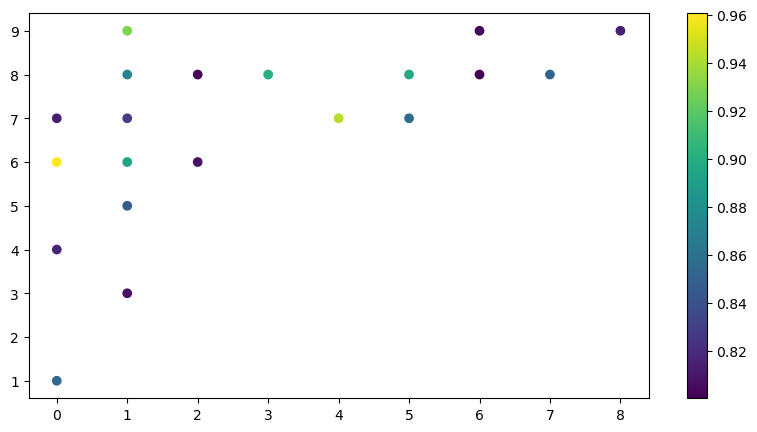

In [8]:
# Check for cross-correlation between the variables

correlation_matrix = X.corr().abs()
# Plot the correlation matrix, since there is 5000 variables,
# we will plot only the variables that have correlation greater than 0.8, 
# preserving the indices of the variables

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
upper = upper.stack().reset_index()
upper.columns = ['var1', 'var2', 'correlation']
upper = upper[upper['correlation'] > 0.8]

plt.figure(figsize=(10, 5))
plt.scatter(upper['var1'], upper['var2'], c=upper['correlation'], cmap='viridis')
plt.colorbar()
plt.show()

In [9]:
# Remove the variables with high correlation

correlated_features = cleanup_dataset_remove_features_correlation(X, threshold=0.8)
print(f'Number of correlated features: {len(correlated_features)}, correlated features: {correlated_features}')

X = X.drop(correlated_features, axis=1)
X_test = X_test.drop(correlated_features, axis=1)

Number of correlated features: 10, correlated features: [1, 0, 4, 6, 7, 3, 5, 8, 9, 2]



The variables with high correlation have been removed - 10 variables out of 500 - it is a good result.

In [10]:
# Check for the variance of the variables

variance_features = cleanup_dataset_remove_features_vif(X, threshold=10)
print(f'Number of variance features: {len(variance_features)}, variance features: {variance_features}')

X = X.drop(variance_features, axis=1)
X_test = X_test.drop(variance_features, axis=1)

Calculating VIF:   2%|▏         | 9/490 [00:11<10:00,  1.25s/it]

KeyboardInterrupt: 

There are no variables with high variance inflation factor (VIF) - it is a good result.

In [11]:
# Check for the distribution of the variables

X = cleanup_dataset_apply_standard_scaler(X)
X_test = cleanup_dataset_apply_standard_scaler(X_test)

The dataset is now cleaned and normalized.

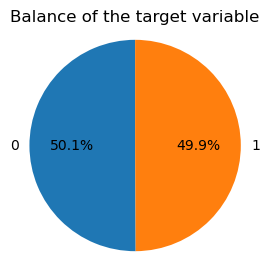

In [12]:
# Check for the class imbalance

target_counts = y.value_counts()

# Plot a pie chart
plt.figure(figsize=(3, 3))
plt.pie(target_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
plt.title('Balance of the target variable')
plt.axis('equal')
plt.show()

The dataset is balanced.

### 3. Feature selection

We will use following methods for feature selection and follow the best performing method for the genetic algorithm:

- mRMR (Minimum Redundancy Maximum Relevance) with Random Forest as the relevance criterion
- SURF (Speeded Up Robust Features)
- Random Forest Classifier with feature importance as the criterion
- XGBoost Classifier with feature importance as the criterion

For every method, we will run the method multiple times to stabilize the results. 
Then as an additional step, we will find the common features among the methods.

This will give us a set of 10 - 20 features that will be used as input for the genetic algorithm given the performance of the feature selection methods.

In [25]:
%pip install skrebate mrmr_selection

Note: you may need to restart the kernel to use updated packages.


In [42]:
selected_features_per_method = {}

In [43]:
from collections import Counter
from utils import feature_selectors
from tqdm import tqdm

iters = 50
for method_key, method in feature_selectors.items():
    if method_key in selected_features_per_method:
        continue
    
    print(f'Applying method: {method_key}')
    
    # To stabilize the results, we will run the method multiple times
    tqdm._instances.clear()
    bar = tqdm(total=iters)
    
    all_selected_features = []
    for iter in range(iters):
        selected_features = method(X, y.values.ravel(), random_state=iter)
        all_selected_features.append(selected_features)
        bar.update(1)
    
    bar.close()
    
    # Find the features that are common among all the iterations
    common_features_counter = Counter(np.concatenate(all_selected_features))
    common_features = [feature for feature, count in common_features_counter.items() if count > 0.9 * iters]
    common_features = pd.Index(common_features)
    
    selected_features_per_method[method_key] = common_features
    print(f'Number of selected features: {len(common_features)}, selected features: {common_features}')


Applying method: mrmr


100%|██████████| 50/50 [03:26<00:00,  4.13s/it]


Number of selected features: 20, selected features: Index([105,  64, 131, 136, 100, 102,  24, 103, 104, 359, 101,  29, 266,  57,
        39, 241, 351, 155, 335, 442],
      dtype='int64')
Applying method: surf


  8%|▊         | 4/50 [09:18<1:47:17, 139.94s/it]

KeyboardInterrupt: 

In [32]:
# Find common features among the methods
most_common_features = Counter(np.concatenate(list(selected_features_per_method.values())))

common_features = [feature for feature, count in most_common_features.items() if count >= 2]
print(f'Number of common features: {len(common_features)}, common features: {common_features}')
selected_features_per_method['common_features'] = list(pd.Index(common_features))

Number of common features: 21, common features: [105.0, 64.0, 131.0, 136.0, 100.0, 102.0, 24.0, 103.0, 104.0, 359.0, 101.0, 29.0, 266.0, 57.0, 39.0, 241.0, 351.0, 155.0, 335.0, 442.0, 403.0]


The amount of common features from the feature selection methods is 21. It is a good number of features that are common between all feature selectors, and we can add these features to the genetic algorithm as they are considered the most important for every method.

In [33]:
# Save the selected features
import pickle

with open('selected_features_per_method.pkl', 'wb') as f:
    pickle.dump(selected_features_per_method, f)

In [13]:
# Load the selected features
import pickle

with open('selected_features_per_method.pkl', 'rb') as f:
    selected_features_per_method = pickle.load(f)

### 4. Model performance comparison

We will compare the performance of the models on the dataset using the features selected by the feature selection algorithms, and on all features of the cleaned dataset.

We will use the following models:
- Random Forest Classifier
- Gradient Boosting Classifier
- MLP Classifier
- SGD Classifier

We will use the score function from the task to evaluate the performance of the models. We also split the dataset into training and testing set to evaluate the performance of the models, and we will run the models multiple times to stabilize the results.

In [14]:
model_results_per_selection_method = {}

In [15]:
from utils import model_appliers, compute_score
from sklearn.model_selection import train_test_split

test_train_split = 0.8
iters = 10

for selection_method_key, selected_features in selected_features_per_method.items():
    for model_key, model in model_appliers.items():
        print(f'Applying model: {model_key} with selection method: {selection_method_key}')
        results = []
        for iter in range(iters):
            X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=test_train_split, random_state=0)
            y_pred = model(X_train, y_train.values.ravel(), X_test, random_state=iter)
            score = compute_score(y_pred, y_test, len(selected_features))
            results.append(score)
            
        if model_key not in model_results_per_selection_method:
            model_results_per_selection_method[model_key] = {}
        model_results_per_selection_method[model_key][selection_method_key] = np.array(results)

Applying model: random_forest with selection method: mrmr
Applying model: gradient_boosting_classifier with selection method: mrmr
Applying model: mlp with selection method: mrmr
Applying model: sgd with selection method: mrmr
Applying model: random_forest with selection method: surf
Applying model: gradient_boosting_classifier with selection method: surf
Applying model: mlp with selection method: surf
Applying model: sgd with selection method: surf
Applying model: random_forest with selection method: forest
Applying model: gradient_boosting_classifier with selection method: forest
Applying model: mlp with selection method: forest
Applying model: sgd with selection method: forest
Applying model: random_forest with selection method: xgb
Applying model: gradient_boosting_classifier with selection method: xgb
Applying model: mlp with selection method: xgb
Applying model: sgd with selection method: xgb
Applying model: random_forest with selection method: common_features
Applying model: gra

In [16]:
# Apply model on all features

for model_key, model in model_appliers.items():
    print(f'Applying model: {model_key} with all features')
    results = []
    for iter in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_train_split, random_state=0)
        y_pred = model(X_train, y_train.values.ravel(), X_test, random_state=iter)
        score = compute_score(y_pred, y_test, X.shape[1])
        results.append(score)

    if model_key not in model_results_per_selection_method:
        model_results_per_selection_method[model_key] = {}
    model_results_per_selection_method[model_key]['all_features'] = np.array(results)

Applying model: random_forest with all features
Applying model: gradient_boosting_classifier with all features
Applying model: mlp with all features
Applying model: sgd with all features


#### Results

We will plot the results for every model and selection method to see which combination gives the best results.
The results are based on the accuracy of the model and then on the selection of the features.

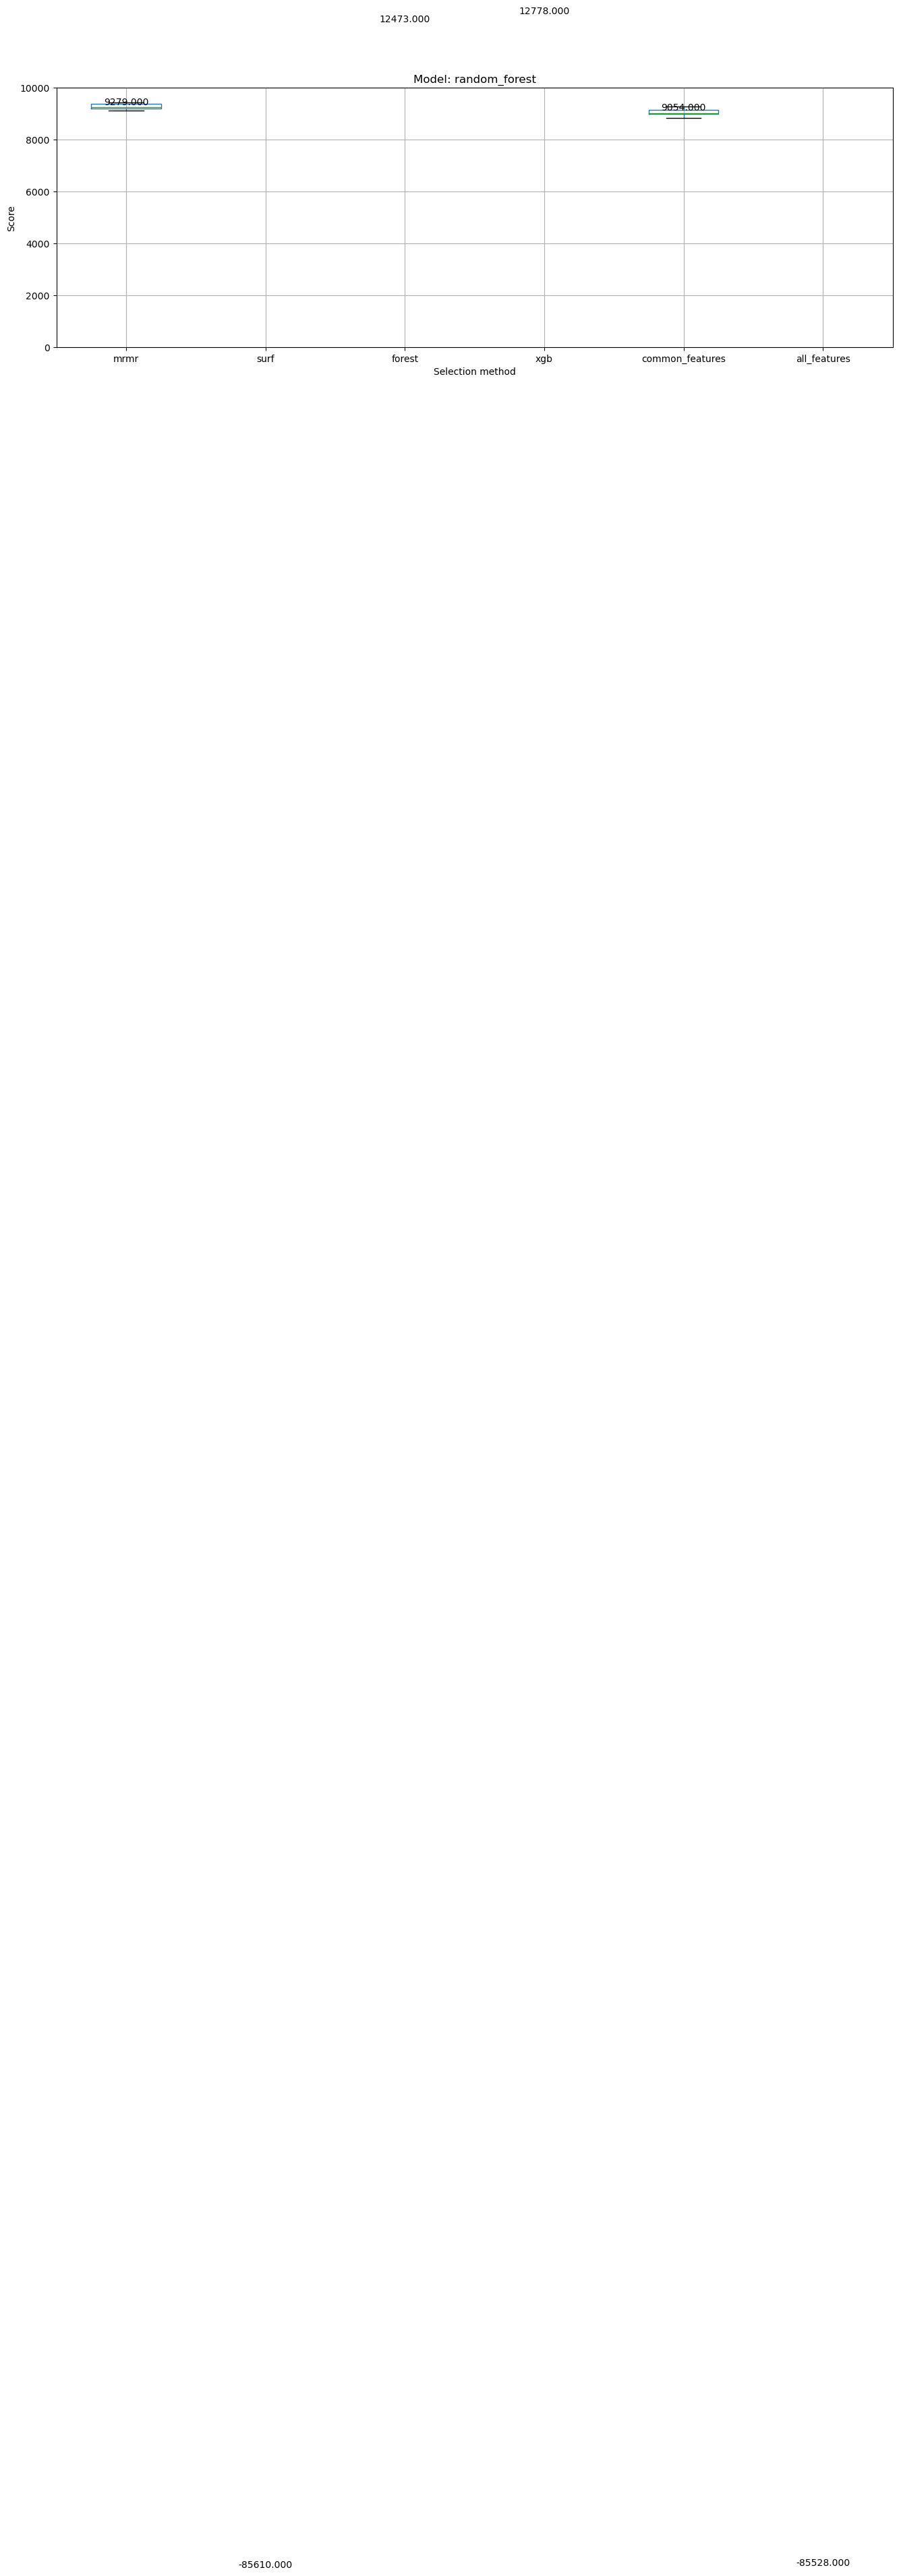

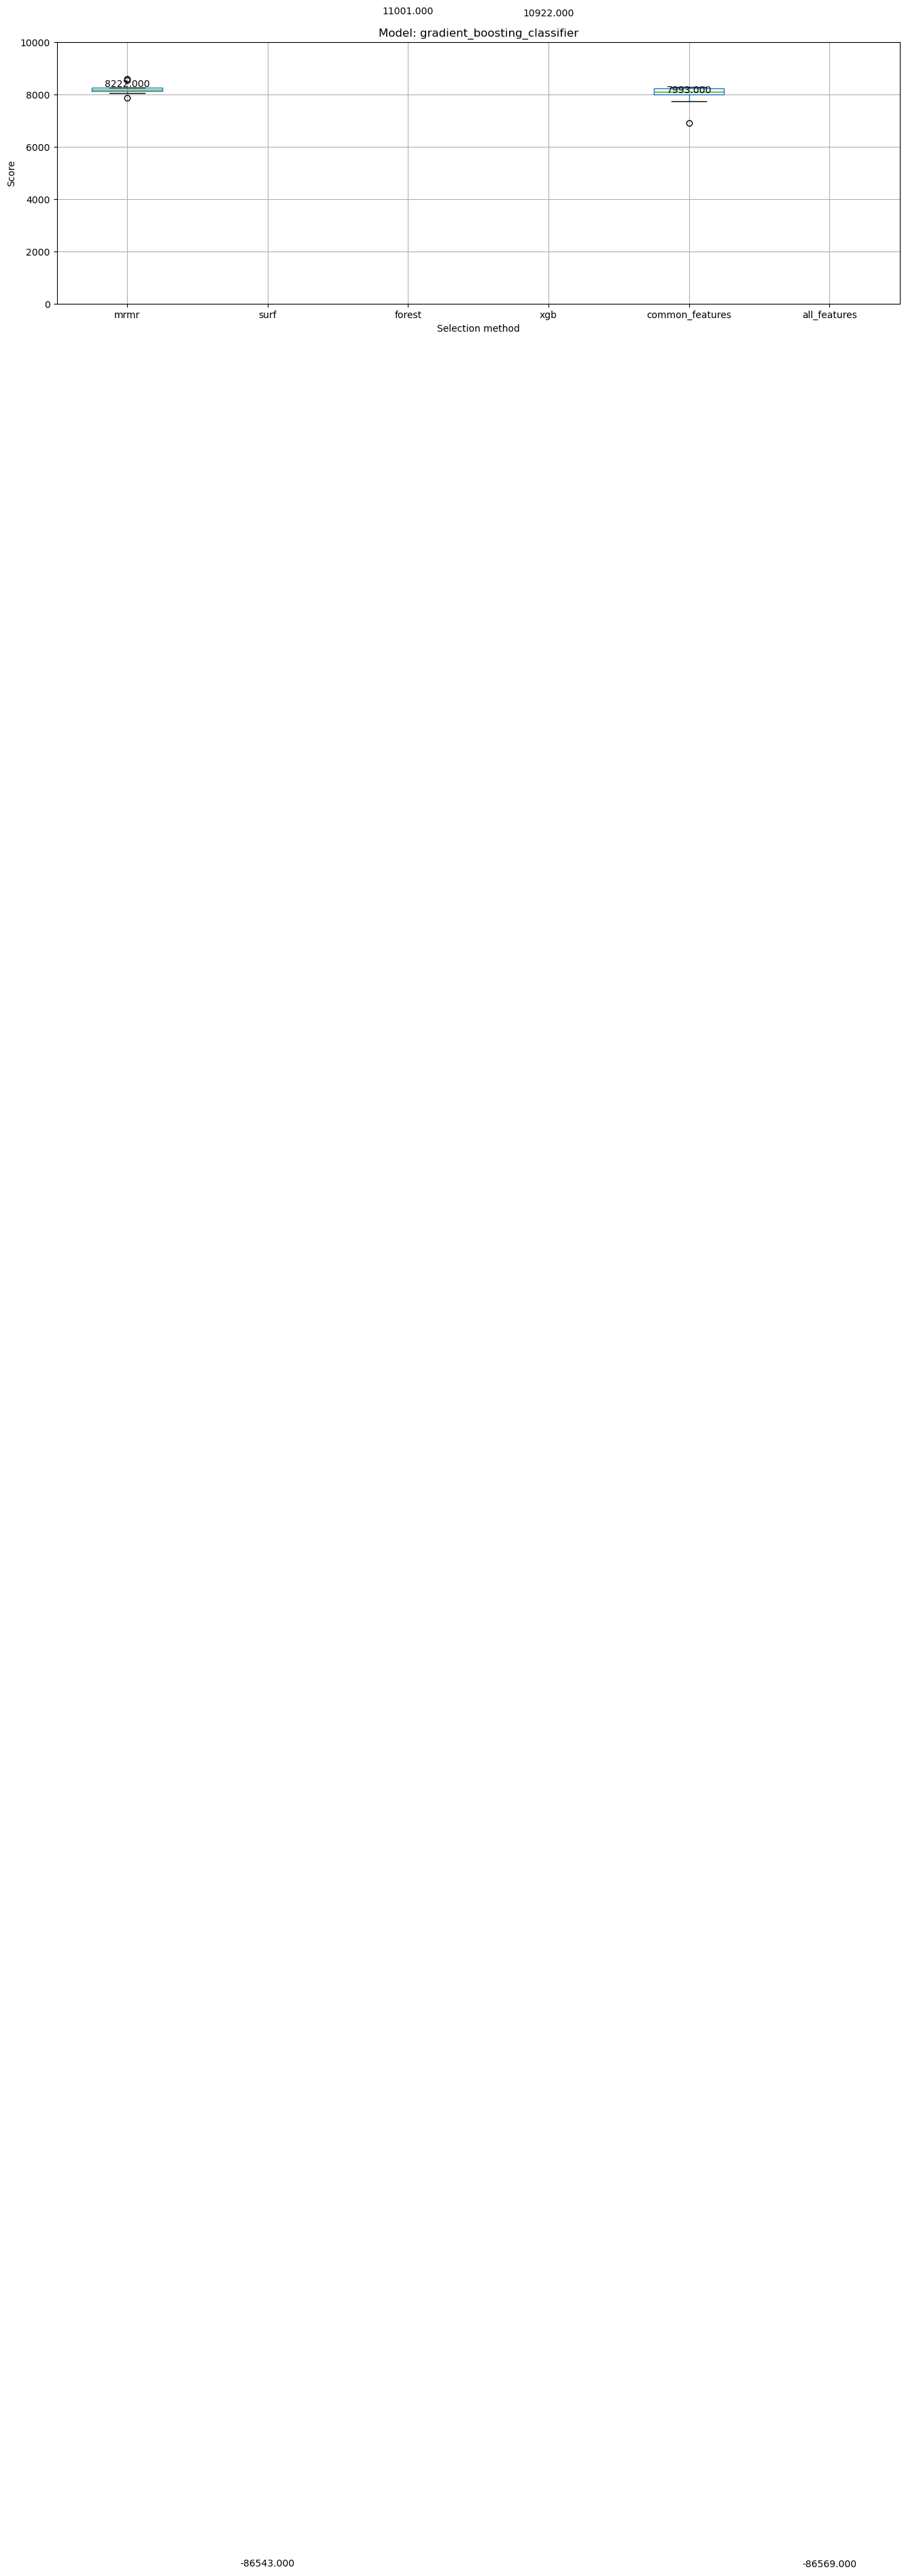

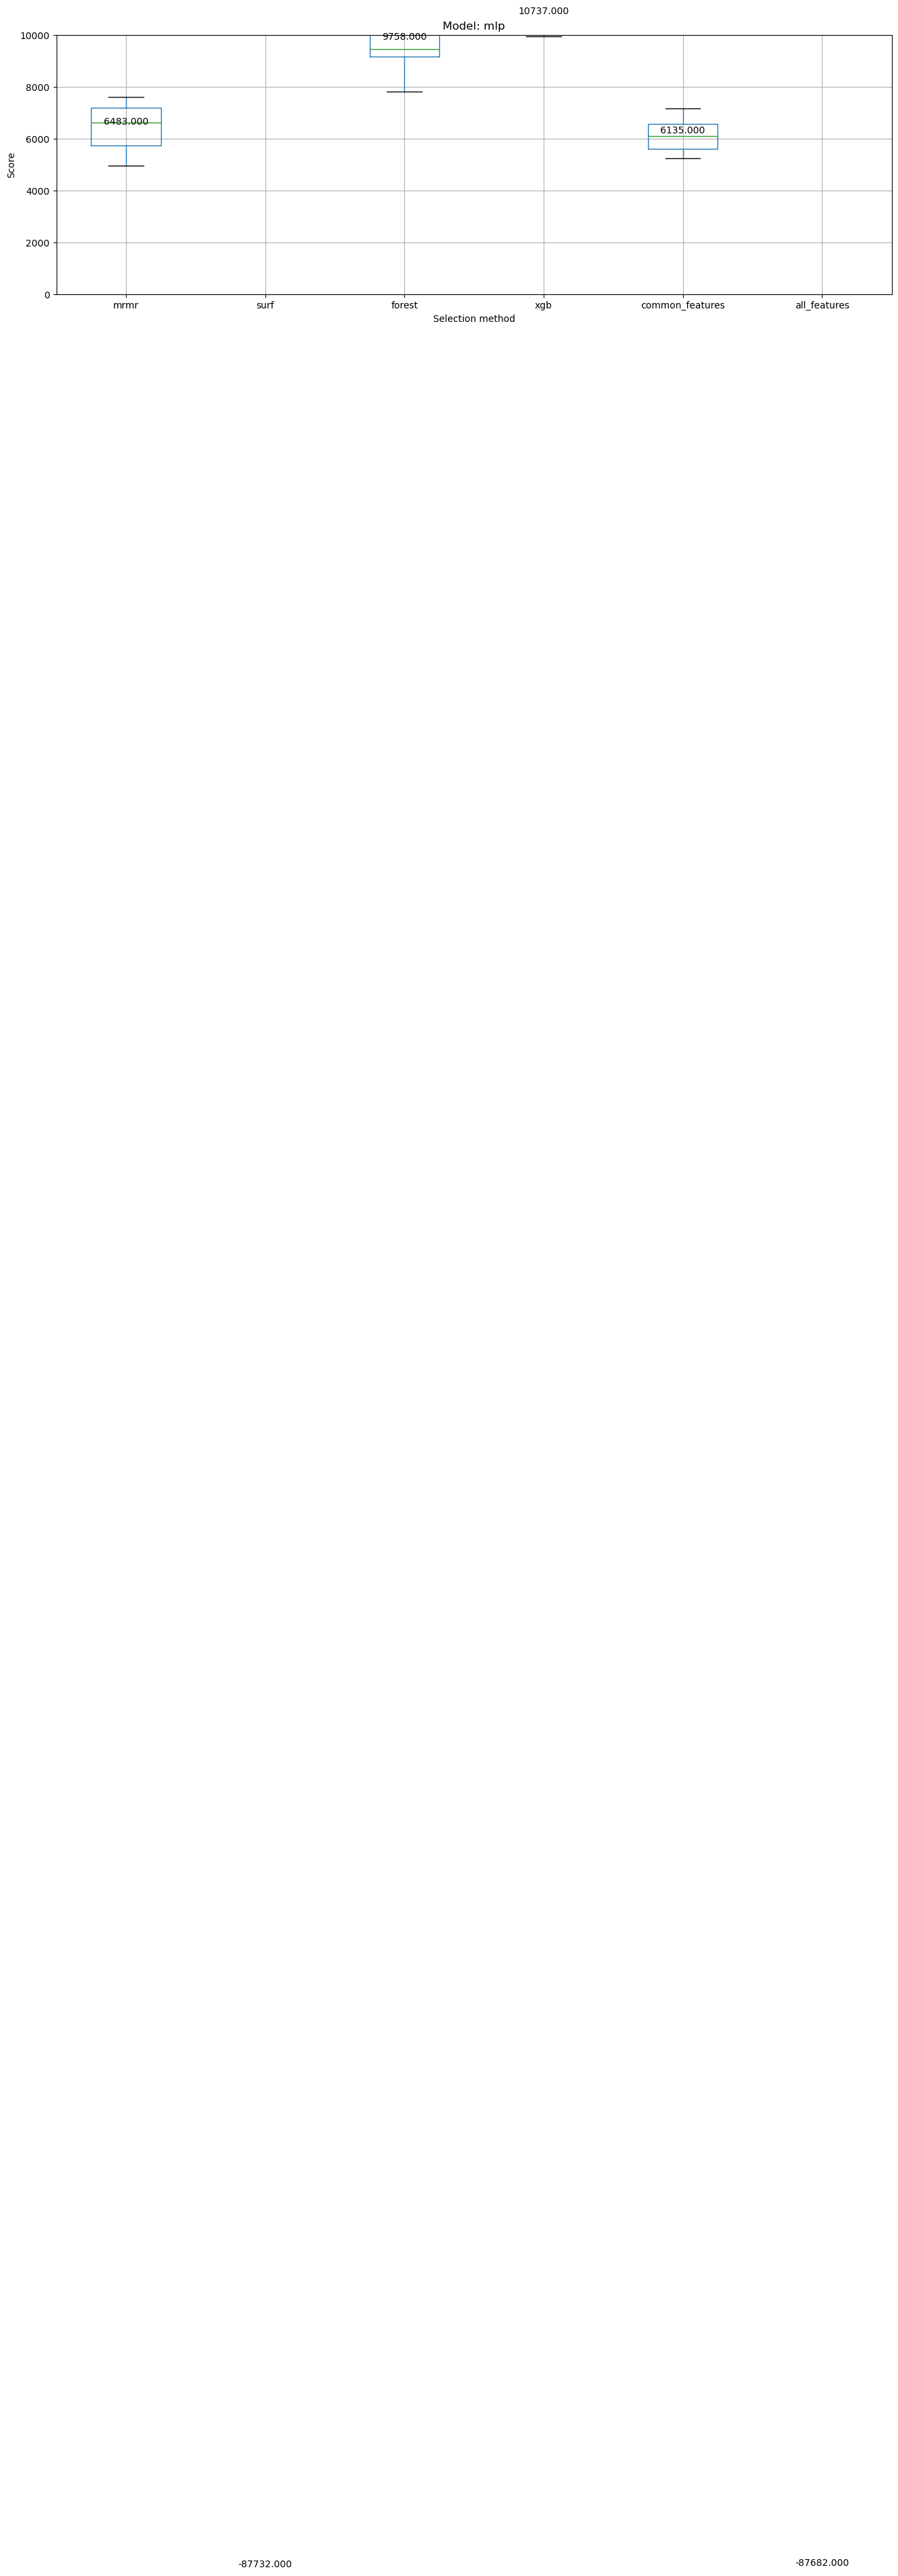

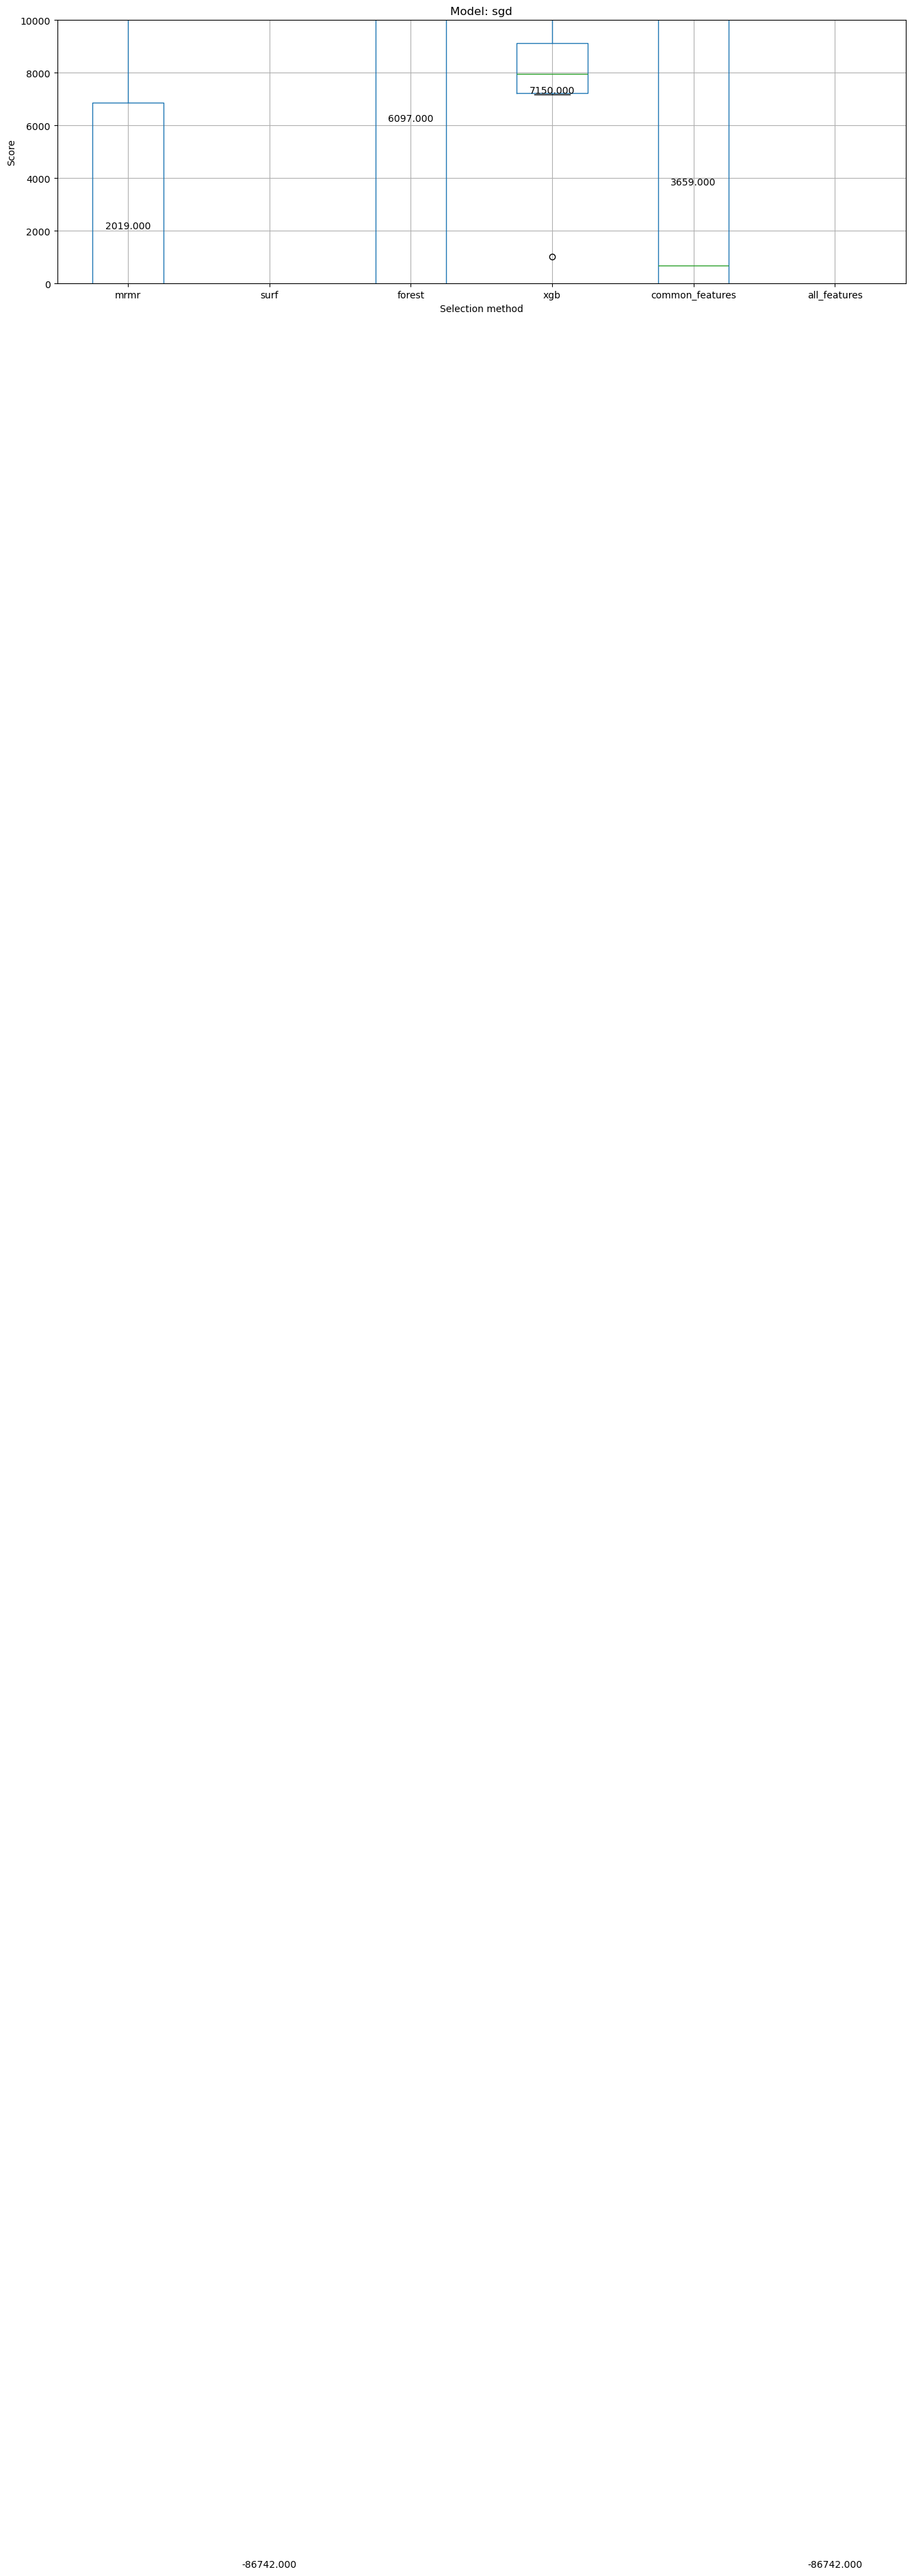

In [17]:
for model_key, model_results in model_results_per_selection_method.items():
    plt.figure(figsize=(16, 5))
    plt.title(f'Model: {model_key}')
    plt.xlabel('Selection method')
    plt.ylabel('Score')
    plt.ylim(0, 10000)

    # Show values for each bar on boxplot
    model_results_df = pd.DataFrame(model_results)
    model_results_df.boxplot()
    
    for i, model_result in zip(range(1, len(model_results) + 1), model_results.values()):
        model_result_mean = model_result.mean()
        plt.text(i, model_result_mean, f'{model_result_mean:.3f}', ha='center', va='bottom')